In [76]:
import pandas as pd
from scipy.spatial import distance
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from math import sin, cos, sqrt, atan2,radians
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVC
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import floorFunctions

In [77]:
df = pd.read_csv("data/Apartments.csv")

/home/alex/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (9,13,18,19,20,21,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [78]:
df.drop(['url', 'source', 'scrapDate', 'images', 'html', 'locationPin', 'localityComplete'], 
        axis='columns', inplace=True)

df = df[df.lat.isnull() == False]

In [79]:
df = df[df.locality == "Bucuresti"]

df.noPark.fillna(value=0, inplace=True)

df['lng_15'] = df['lng']*np.cos(15* np.pi / 180) - df['lat']*np.sin(15* np.pi/180)                                                                                 
df['lng_30'] = df['lng']*np.cos(30* np.pi / 180) - df['lat']*np.sin(30* np.pi/180)
df['lng_45'] = df['lng']*np.cos(45* np.pi / 180) - df['lat']*np.sin(45* np.pi/180)
df['lng_60'] = df['lng']*np.cos(60* np.pi / 180) - df['lat']*np.sin(60* np.pi/180)
df['lng_75'] = df['lng']*np.cos(75* np.pi / 180) - df['lat']*np.sin(75* np.pi/180)
                                                                                 
df['lat_15'] = df['lng']*np.sin(15* np.pi / 180) + df['lat']*np.cos(15* np.pi/180)
df['lat_30'] = df['lng']*np.sin(30* np.pi / 180) + df['lat']*np.cos(30* np.pi/180)
df['lat_45'] = df['lng']*np.sin(45* np.pi / 180) + df['lat']*np.cos(45* np.pi/180)
df['lat_60'] = df['lng']*np.sin(60* np.pi / 180) + df['lat']*np.cos(60* np.pi/180)
df['lat_75'] = df['lng']*np.sin(75* np.pi / 180) + df['lat']*np.cos(75* np.pi/180)

floorTypeDict = {}
for e in df.floor.unique():
    floorTypeDict[e] = floorFunctions.getValidCell(e)
for idx, row in df.iterrows():
    df.loc[idx, 'floorType'] = floorTypeDict[row['floor']]
    
    
test = df.sample(frac=0.20)
train = df.drop(test.index)

# buc100 = pd.read_csv("TestBucuresti100.csv")
# train = df
# test = buc100

print(f'train: {len(train)} test: {len(test)}')

train: 8254 test: 2063


In [80]:
categ_features = [
    'condition',
    'constructionYearRange',
    'typeOfBuilding',
    'structure',
    'floorType',
    'partitioning',
]

numeric_features = [
    'usableArea', 
#     'buildingArea',
#     'totalUsableArea', 
    'rooms',
    'balconies',
    'kitchens',
    'bathrooms',
    'noPark',
    'lat',
    'lng',
    'lng_15',
    'lng_30',
    'lng_45',
    'lng_60',
    'lng_75',
    'lat_15',
    'lat_30',
    'lat_45',
    'lat_60',
    'lat_75',
]

# Add missing columns to test data (values are most common values in train)
for c in categ_features + numeric_features:
    if c not in test.columns:
        print(f'{c} missing in train')
        test[c] = [train[c].value_counts().index[0] for i in range(len(test))]
        
test.head()

,_id,price,locality,district,area,rooms,usableArea,buildingArea,partitioning,condition,...,lng_30,lng_45,lng_60,lng_75,lat_15,lat_30,lat_45,lat_60,lat_75,floorType
40826,92O00JGHAQF,79571.0,Bucuresti,B,Crangasi,2,67,76,decomandat,1,...,0.336499,-13.011117,-25.472047,-36.197099,49.684098,51.526927,49.858282,44.791878,36.672980,parter
9182,3RN00E1BCSL,149000.0,Bucuresti,B,Iancu Nicolae,3,145,165,decomandat,1,...,0.384257,-12.989938,-25.478891,-36.231499,49.764859,51.623334,49.963765,44.899247,36.774921,ultimul etaj
28171,78O00JQAL3V,129000.0,Bucuresti,B,Mihai Bravu,3,103,112,decomandat,1,...,0.420049,-12.928959,-25.396879,-36.134045,49.657042,51.521305,49.874476,44.828783,36.728084,intermediar
52392,ALQ1000QL1L,27500.0,Bucuresti,B,Militari,1,32,35,decomandat,1,...,0.285339,-13.049527,-25.495089,-36.203202,49.656259,51.484398,49.803961,44.729466,36.606732,intermediar
25617,6PO00JRIOLP,72500.0,Bucuresti,B,Berceni,3,68,75,semidecomandat,1,...,0.427815,-12.913101,-25.374010,-36.105722,49.623844,51.489017,49.845298,44.804704,36.710744,parter


In [81]:
import re
regex = re.compile("\([^()]*\)")

def sanitizeString(s):
    if s is None:
        return s
    if type(s) is str:
        s = re.sub(regex, '', s)
        s = s.replace(",", ".")
        s = float(s)
        return s
    else:
        return float(s)
    
for num_col in numeric_features:
    test[num_col] = test[num_col].apply(sanitizeString)
    train[num_col] = train[num_col].apply(sanitizeString)

for categ_col in categ_features:
    test[categ_col] = test[categ_col].astype(str)
    train[categ_col] = train[categ_col].astype(str)

# replace nan with mith the most frequent value from one column
train = train.apply(lambda x:x.fillna(x.value_counts().index[0])) 
test = test.apply(lambda x:x.fillna(x.value_counts().index[0])) 

In [82]:
for c in categ_features:
    print(f'{c} : {train[c].unique()}')

cate_label_train = train[categ_features]
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(cate_label_train)

transformer = RobustScaler().fit(train[numeric_features])

condition : ['1' 'lux' '2' '3' '0']
constructionYearRange : ['dupa2000' 'intre1960si1977' 'inainte1960' 'intre1977si2000' 'nan']
typeOfBuilding : ['bloc de apartamente' 'casa/vila' 'nan']
structure : ['beton' '0' 'caramida' 'altele' 'bca' 'lemn' 'metal']
floorType : ['parter' 'intermediar' 'ultimul etaj']
partitioning : ['decomandat' 'semidecomandat' 'vagon' 'nedecomandat' 'circular' '0']


In [83]:
def gen_labels(df):
    numerical_features = df[numeric_features]
    transformer.transform(numerical_features)
    
    categorical_features = df[categ_features]
    enc_categ_f = enc.transform(categorical_features)
    
    df_num_and_catg = pd.concat([
        numerical_features.reset_index(drop=True),
#         pd.DataFrame(transformer.transform(numerical_features)),
        pd.DataFrame(enc_categ_f.toarray())
    ], axis=1)
#     print(df_num_and_catg)
    return df_num_and_catg

train_X = gen_labels(train) 
train_y = train[['price']].values.ravel()

In [84]:
train_X.head()

,usableArea,rooms,balconies,kitchens,bathrooms,noPark,lat,lng,lng_15,lng_30,...,19,20,21,22,23,24,25,26,27,28
0,64.0,2.0,1.0,1.0,1.0,1.0,44.403778,25.985014,13.607053,0.301793,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,60.8,2.0,1.0,1.0,1.0,1.0,44.403723,25.984961,13.607016,0.301775,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,65.1,2.0,1.0,1.0,1.0,1.0,44.403643,25.984746,13.606829,0.301629,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,61.0,2.0,1.0,1.0,1.0,1.0,44.403735,25.984789,13.606847,0.301620,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,71.3,2.0,1.0,1.0,1.0,1.0,44.403648,25.984767,13.606848,0.301645,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [90]:
model = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05,
                                   max_depth=5, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model.fit(train_X, train_y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='huber',
                          max_depth=5, max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=5000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=5, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [85]:
model = XGBRegressor(objective='reg:squarederror')
model.fit(train_X, train_y)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [91]:
test_X = gen_labels(test)
test_y = test[['price']].values.ravel()

In [92]:
pred = model.predict(test_X)

In [109]:
r = np.array(test_y)
p = np.array(pred)
# print(f'Eroare procentuala absoluta medie: {sum(abs(100*((r-p)/r))/len(r))}')
min(r)

0.0

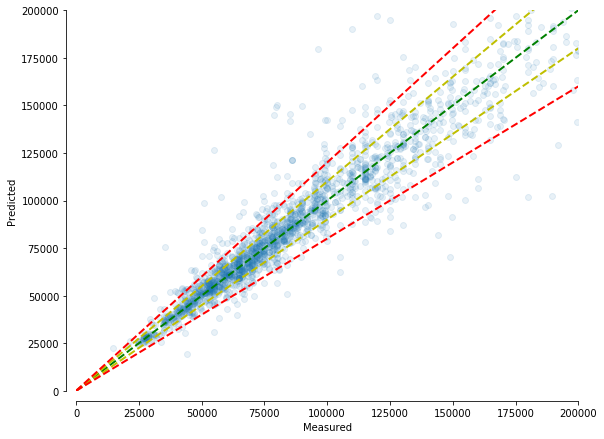

In [114]:
import matplotlib.pyplot as plt
import numpy as np
def plot_regression_results(ax, y_true, y_pred, interval=[10000, 1000000]):
    """Scatter plot of the predicted vs true targets."""
    ax.plot(interval,
            interval,
            '--g', linewidth=2)
    ax.plot(interval, [i*0.9 for i in interval], '--y', linewidth=2)
    ax.plot(interval, [i*1.1 for i in interval], '--y', linewidth=2)
    ax.plot(interval, [i*0.8 for i in interval], '--r', linewidth=2)
    ax.plot(interval, [i*1.2 for i in interval], '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.1)
    
    ax.set_xlim(interval)
    ax.set_ylim(interval)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
#     ax.set_xlim([y_true.min(), y_true.max()])
#     ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')

    plt.show()

fig, axs = plt.subplots(1, 1, figsize=(9, 7))
axs = np.ravel(axs)

plot_regression_results(axs[0], test_y, pred, [0,200000])